In [34]:
import pandas as pd
from database_handler import execute_query,create_connection,return_data_as_df
from lookups import InputTypes

db_session = create_connection()
query = """ SELECT * FROM dw_reporting.dim_gdp_all_measures
 """

df = return_data_as_df(query,InputTypes.SQL,db_session)
df

c:\Users\user\OneDrive\Documents\SE_Factory\FSD\Final_Project\usa_recession_analysis\database_handler.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return_dataframe = pd.read_sql_query(con= db_session, sql= file_executor)


,date,gdp,pce,gpdi,netexp,gcec,impgs
0,2007-01-01,16611.690,28716.4,2664.295,-739.273,3299.115,2317.264
1,2007-04-01,16713.314,29036.2,2699.217,-745.806,3329.139,2368.569
2,2007-07-01,16809.587,29395.1,2685.969,-728.954,3344.222,2414.664
3,2007-10-01,16915.191,29811.4,2642.560,-729.699,3370.950,2480.413
4,2008-01-01,16843.003,30013.4,2563.701,-771.248,3378.654,2584.568
...,...,...,...,...,...,...,...
61,2022-04-01,21708.160,52245.3,4739.049,-1025.567,3641.161,4069.839
62,2022-07-01,21851.134,53052.6,4724.621,-892.026,3666.982,3976.524
63,2022-10-01,21989.981,53751.2,4796.162,-877.204,3714.800,3891.004
64,2023-01-01,22112.329,54808.7,4725.828,-825.687,3758.768,3890.491


In [35]:
df['date']

0     2007-01-01
1     2007-04-01
2     2007-07-01
3     2007-10-01
4     2008-01-01
         ...    
61    2022-04-01
62    2022-07-01
63    2022-10-01
64    2023-01-01
65    2023-04-01
Name: date, Length: 66, dtype: object

In [36]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt



# Set the 'date' column as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Select relevant columns
columns_to_use = ['gdp', 'pce', 'gpdi', 'netexp', 'gcec', 'impgs']
df = df[columns_to_use]



### differencing

In [37]:
# You can use the adfuller function from statsmodels for the ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['gdp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.6853868216176305
p-value: 0.9895416810729587


In [38]:
df['gdp_diff'] = df['gdp'].diff()

In [39]:
result_diff = adfuller(df['gdp_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic: -6.869334573493591
p-value: 1.5299063683304448e-09


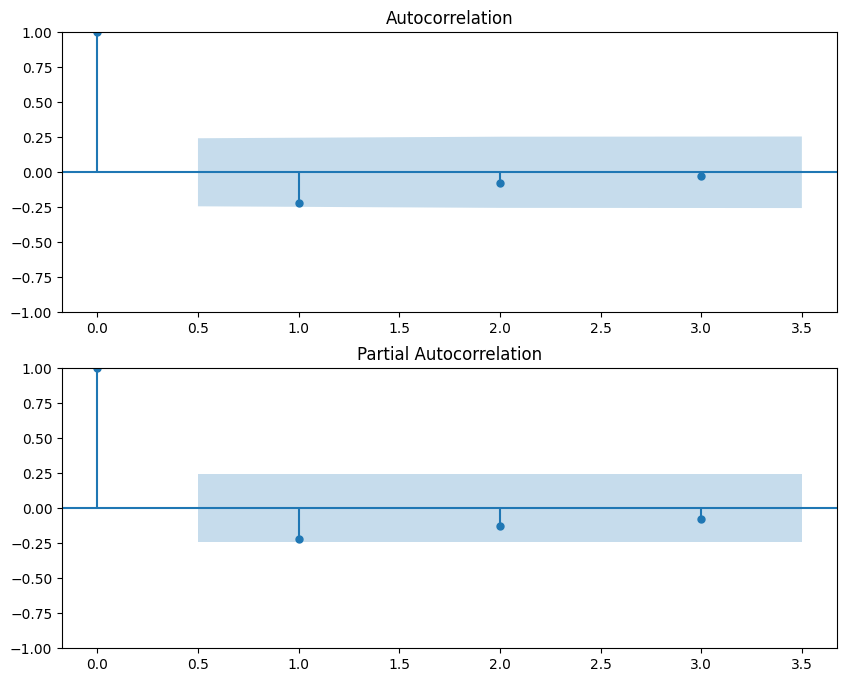

In [40]:
# Example of ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df['gdp_diff'].dropna(), lags=3, ax=ax1)
plot_pacf(df['gdp_diff'].dropna(), lags=3, ax=ax2)

plt.show()


In [74]:
# # Check for missing values and fill or drop them if necessary
# df = df.dropna()

# Fit ARIMA model
#314
model = ARIMA(df['gdp'], order=(3, 1, 4))  # You may need to experiment with order values
result = model.fit()

c:\Users\user\anaconda3\envs\sefactory_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\sefactory_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\sefactory_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\sefactory_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user\anaconda3\envs\sefactory_env\lib\

In [75]:
# Make predictions for future periods
future_periods = 80  # Adjust as needed
forecast = result.get_forecast(steps=future_periods)


In [76]:
# Get the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [105]:
predicted_values.index.name = 'date'
predicted_values

date
2023-07-01    22268.304450
2023-10-01    22327.942302
2024-01-01    22397.615920
2024-04-01    22474.808669
2024-07-01    22556.984931
                  ...     
2042-04-01    29280.674146
2042-07-01    29375.704725
2042-10-01    29470.950943
2043-01-01    29565.981070
2043-04-01    29661.226805
Freq: QS-OCT, Name: predicted_mean, Length: 80, dtype: float64

In [100]:
confidence_intervals

,lower gdp,upper gdp
2023-07-01,21629.730632,22906.878268
2023-10-01,21513.387537,23142.497068
2024-01-01,21478.946907,23316.284933
2024-04-01,21485.209298,23464.408039
2024-07-01,21514.438867,23599.530994
...,...,...
2042-04-01,26460.715061,32100.633231
2042-07-01,26530.836326,32220.573125
2042-10-01,26601.159272,32340.742614
2043-01-01,26671.262779,32460.699362


In [85]:
predicted_values_indexed = predicted_values.reset_index()

In [79]:
future_dates = pd.date_range(start=df.index.max(), periods=future_periods + 1, freq='M')[1:]
future_dates

DatetimeIndex(['2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31',
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31', '2025-11-30', '2025-12-31',
               '2026-01-31', '2026-02-28', '2026-03-31', '2026-04-30',
               '2026-05-31', '2026-06-30', '2026-07-31', '2026-08-31',
               '2026-09-30', '2026-10-31', '2026-11-30', '2026-12-31',
               '2027-01-31', '2027-02-28', '2027-03-31', '2027-04-30',
               '2027-05-31', '2027-06-30', '2027-07-31', '2027-08-31',
               '2027-09-30', '2027-10-31', '2027-11-30', '2027-12-31',
      

In [95]:
indexed_predicted_values = predicted_values.reset_index()
indexed_predicted_values.columns = ['date','forecasted_gdp']
indexed_predicted_values

,date,forecasted_gdp
0,2023-07-01,22268.304450
1,2023-10-01,22327.942302
2,2024-01-01,22397.615920
3,2024-04-01,22474.808669
4,2024-07-01,22556.984931
...,...,...
75,2042-04-01,29280.674146
76,2042-07-01,29375.704725
77,2042-10-01,29470.950943
78,2043-01-01,29565.981070


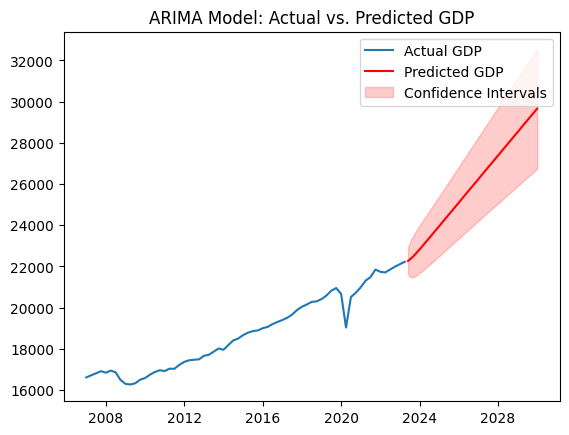

In [80]:
# Plot the actual values
plt.plot(df['gdp'], label='Actual GDP')

# Plot the predicted values
plt.plot(future_dates, predicted_values, label='Predicted GDP', color='red')

# Plot confidence intervals if needed
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='red', alpha=0.2, label='Confidence Intervals')

# Display the plot
plt.legend()
plt.title('ARIMA Model: Actual vs. Predicted GDP')
plt.show()